In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

In [ ]:
import pandas as pd

df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [ ]:
with open("jena_climate_2009_2016.csv") as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")

lines = lines[1:]

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),)) # (420451,)
raw_data = np.zeros((len(lines), len(header) - 1)) # (420451, 14)

# i, line
# 0, '01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'
# 1, '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10'
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  # values = 996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'
  # values = 996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10'
  temperature[i] = values[1]
  # temperature = -8.02
  # temperature = -8.41
  raw_data[i,:] = values[:]
  # raw_data shape = 420451, 14
  # raw_data[0, :], meaning all columns are basically all values including temperature

In [ ]:
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

In [ ]:
# instantiating datasets for training, validation, and testing

# number of raw timesteps to skip between consecutive samples in the sequence means choose every 6th row
sampling_rate = 6 # 1 measurement every 10 minutes = 6 measurements per hour, pick 1 point per hour


# For each training example, take 120 timesteps,
# but each timestep should be separated by 6 rows in the raw data.
sequence_length = 120 # 120 hours of history (5 days)


# Given an input window that starts at index i, the target value is at index i + delay.
# 6 * 143
# 858 raw rows ahead
delay = sampling_rate * (sequence_length + 24 - 1)

batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    # predicting 24 hours beyond the END of the 5-day window
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)


val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples

)

In [ ]:
# Each dataset yields a tuple of (samples, targets) where samples is a batch of 256 samples, each containing 120 consecutive hours of input data
# Targets is corresponding array of 256 target temperatures

In [ ]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
train_dataset = train_dataset.unbatch().batch(256, drop_remainder=True)
val_dataset   = val_dataset.unbatch().batch(256, drop_remainder=True)
test_dataset  = test_dataset.unbatch().batch(256, drop_remainder=True)


In [ ]:
# A first recurrent baseline

# The densely connected approach first flattened the timeseries, which removed the notion of time from the input data.
# The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information.

# Now, A sequence, where causality and order matter
# a family of neural network architectures designed specifically for this use case: recurrent neural networks.
# Among them, the Long Short Term Memory (LSTM) layer has been very popular

In [ ]:
# A simple LSTM-based model
from tensorflow.keras import layers
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only = True)
]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])

history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

# We achieve a Validation MAE as low as  2.41 degrees and a test MAE of 2.55 degrees.
# The LSTM-based model can finally beat the common-sense baseline, demonstrating the value of ML on this task.

Epoch 1/10
    816/Unknown 38s 45ms/step - loss: 73.0994 - mae: 6.5346

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


818/818 ━━━━━━━━━━━━━━━━━━━━ 55s 66ms/step - loss: 72.9867 - mae: 6.5280 - val_loss: 12.5705 - val_mae: 2.6988
Epoch 2/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 12.1822 - mae: 2.6960 - val_loss: 9.5049 - val_mae: 2.4120
Epoch 3/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 10.2423 - mae: 2.4938 - val_loss: 10.7391 - val_mae: 2.4564
Epoch 4/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 9.6470 - mae: 2.4212 - val_loss: 10.8367 - val_mae: 2.4609
Epoch 5/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 9.2464 - mae: 2.3725 - val_loss: 10.4890 - val_mae: 2.4391
Epoch 6/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 90s 109ms/step - loss: 8.9371 - mae: 2.3312 - val_loss: 9.4583 - val_mae: 2.3761
Epoch 7/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 8.7098 - mae: 2.2989 - val_loss: 9.6630 - val_mae: 2.3797
Epoch 8/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 8.4392 - mae: 2.2637 - val_loss: 11.4240 - val_mae: 2.4861
Epoch 9/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 48

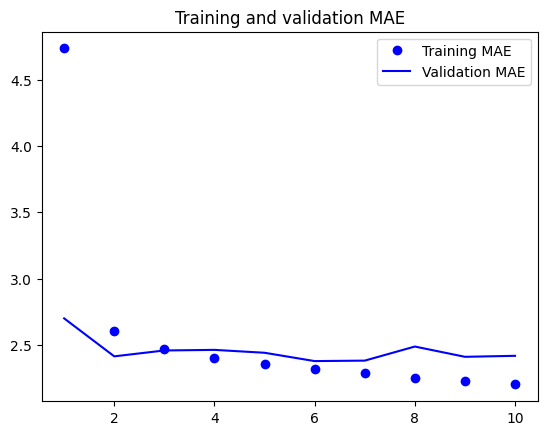

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss = history_dict["mae"]
val_loss = history_dict["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, "b", label = "Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()